In [1]:
!pip3 install onnxruntime

  Using cached sympy-1.12-py3-none-any.whl.metadata (12 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 3.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 386.8 kB/s eta 0:00:000:00:01
Using cached sympy-1.12-py3-none-any.whl (5.7 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 889.5 kB/s eta 0:00:00 0:00:01
Using cached mpmath-1.3.0-py3-none-any.whl (536 kB)


In [2]:
import onnxruntime as rt
import numpy as np
import cv2
import json
import matplotlib.pyplot as plt
import random
import requests
from tqdm import tqdm
import shutil


In [3]:
def download_file(url, save):

    re = requests.get(url, stream=True)

    file_size = int(re.headers.get('Content-Length', 0))
    with tqdm.wrapattr(re.raw, "read", total=file_size) as r:
        with open(save, 'wb') as f:
            shutil.copyfileobj(r, f)

In [4]:
download_file('https://models.arz.ai/ocr_v2.onnx', './model.onnx')
download_file('https://models.arz.ai/ocr_v2.json', './keys.json')

100%|██████████| 146M/146M [00:14<00:00, 10.4MB/s] 
100%|██████████| 745/745 [00:00<00:00, 650kB/s]


In [5]:
# providers = ['CUDAExecutionProvider']
providers = ['CPUExecutionProvider']
model = rt.InferenceSession('./model.onnx', providers=providers)
output_name = model.get_outputs()[0].name
input_name = model.get_inputs()[0].name

In [6]:
ltx_index = json.load((open('keys.json')))

In [9]:
data = json.load(open("/home/diegoberan/code/ChilleeX/NoLaTeX/initial_test_data/kaggle_data_1.json"))

In [10]:
def resize(img, w=256, h=256):
    p = max(img.shape[:2] / np.array([h, w]))
    s = img.shape[:2]
    r = s / p

    img = cv2.resize(img, (int(r[1]), int(r[0])))

    re = np.zeros((h, w, 3))
    offset = np.array((np.array(re.shape[:2]) - np.array(img.shape[:2])) / 2, dtype=np.int32)
    re[offset[0]:offset[0] + img.shape[0], offset[1]:offset[1] + img.shape[1]] = img
    return re

def load(image_file, w, h):
    i = cv2.imread(image_file)[...,::-1]
    input_image = resize(i, w, h) / 255
    return input_image[None].astype(np.float32)


In [20]:
idx = random.choice(data)
print(idx['filename'])
print(idx['latex'])

c83050a3-dab2-4d13-b2c5-0f4143e2e31f.jpg
\lim_{g\to1^{+}}\frac{\frac{d}{dg}\left(5+-2\cos^{7}{g}\right)}{\frac{d}{dg}\left(\sin{g}+g\sin^{6}{g}\right)}


\lim_{g\to1^{+}}\frac{\frac{d}{dg}\left(5+-2\cos^{7}{g}\right)}{\frac{d}{dg}\left(\sin{g}+g\sin^{6}{g}\right)}                                                      
\lim_{g\to1^{+}}\frac{\frac{d}{dg}\left(5+-2\cos^{7}{g}\right)}{\frac{d}{dg}\left(\sin{g}+g\sin^{6}{g}\right)}


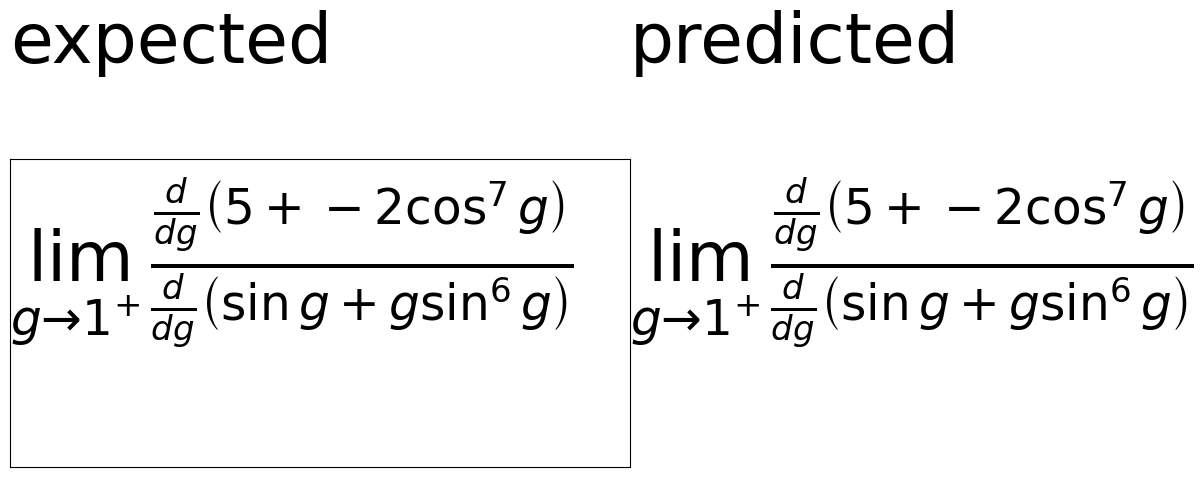

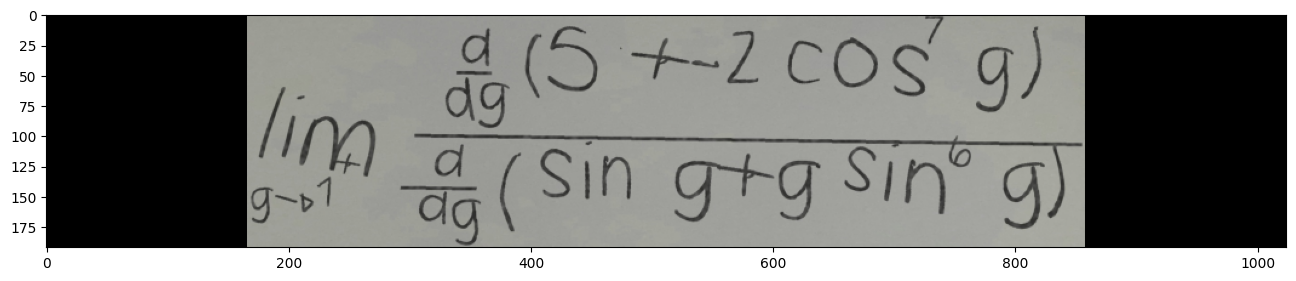

In [22]:
#idx = random.choice(data)
img = load('/home/diegoberan/code/ChilleeX/NoLaTeX/initial_test_data/onnx/c83050a3-dab2-4d13-b2c5-0f4143e2e31f.jpg', w=1024, h=192)
res = model.run([output_name], {input_name: img})[0][0]
res = np.argmax(res, axis=1)

l = ''.join([ltx_index[str(x - 1)] if x != 0 else ' ' for x in res])
e = idx['latex']

print(l)
print(e)

plt.figure(figsize=(8, 4))
plt.text(0, 0.6, 'expected\n\n' + r"$%s$" % e, fontsize=50)
plt.text(1, 0.6, 'predicted\n\n' + r"$%s$" % l, fontsize=50)

fig = plt.gca()
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)

im = img[0]

plt.figure(figsize=(16, 16))
plt.imshow(im)
